In [1]:
%matplotlib inline


# Cropped Decoding on BCIC IV 2a Dataset


Building on the `Trialwise decoding
tutorial <./plot_bcic_iv_2a_moabb_trial.html>`__, we now do more
data-efficient cropped decoding!




In Braindecode, there are two supported configurations created for
training models: trialwise decoding and cropped decoding. We will
explain this visually by comparing trialwise to cropped decoding.

<img src="file://../_static/trialwise_explanation.png">
<img src="file://../_static/cropped_explanation.png">

On the left, you see trialwise decoding:

1. A complete trial is pushed through the network.
2. The network produces a prediction.
3. The prediction is compared to the target (label) for that trial to
   compute the loss.

On the right, you see cropped decoding:

1. Instead of a complete trial, crops are pushed through the network.
2. For computational efficiency, multiple neighbouring crops are pushed
   through the network simultaneously (these neighbouring crops are
   called compute windows)
3. Therefore, the network produces multiple predictions (one per crop in
   the window)
4. The individual crop predictions are averaged before computing the
   loss function

<div class="alert alert-info"><h4>Note</h4><p>-  The network architecture implicitly defines the crop size (it is the
       receptive field size, i.e., the number of timesteps the network uses
       to make a single prediction)
    -  The window size is a user-defined hyperparameter, called
       ``input_window_samples`` in Braindecode. It mostly affects runtime
       (larger window sizes should be faster). As a rule of thumb, you can
       set it to two times the crop size.
    -  Crop size and window size together define how many predictions the
       network makes per window: ``#window−#crop+1=#predictions``</p></div>




<div class="alert alert-info"><h4>Note</h4><p>For cropped decoding, the above training setup is mathematically
    identical to sampling crops in your dataset, pushing them through the
    network and training directly on the individual crops. At the same time,
    the above training setup is much faster as it avoids redundant
    computations by using dilated convolutions, see our paper
    `Deep learning with convolutional neural networks for EEG decoding and visualization <https://arxiv.org/abs/1703.05051>`_.
    However, the two setups are only mathematically identical in case (1)
    your network does not use any padding or only left padding and
    (2) your loss function leads
    to the same gradients when using the averaged output. The first is true
    for our shallow and deep ConvNet models and the second is true for the
    log-softmax outputs and negative log likelihood loss that is typically
    used for classification in PyTorch.</p></div>




## Loading and preprocessing the dataset




Loading and preprocessing stays the same as in the `Trialwise decoding
tutorial <./plot_bcic_iv_2a_moabb_trial.html>`__.




In [3]:
import sys
sys.path.append("../moabb") 
from braindecode.datasets.moabb import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

from braindecode.datautil.preprocess import (
    exponential_moving_standardize, preprocess, Preprocessor)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda x: x * 1e6),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors)

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 

## Create model and compute windowing parameters




In contrast to trialwise decoding, we first have to create the model
before we can cut the dataset into windows. This is because we need to
know the receptive field of the network to know how large the window
stride should be.




We first choose the compute/input window size that will be fed to the
network during training This has to be larger than the networks
receptive field size and can otherwise be chosen for computational
efficiency (see explanations in the beginning of this tutorial). Here we
choose 1000 samples, which are 4 seconds for the 250 Hz sampling rate.




In [4]:
input_window_samples = 1000

Now we create the model. To enable it to be used in cropped decoding
efficiently, we manually set the length of the final convolution layer
to some length that makes the receptive field of the ConvNet smaller
than ``input_window_samples`` (see ``final_conv_length=30`` in the model
definition).




In [5]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
)

# Send model to GPU
if cuda:
    model.cuda()

And now we transform model with strides to a model that outputs dense
prediction, so we can use it to obtain predictions for all
crops.




In [6]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape
to_dense_prediction_model(model)

To know the models’ receptive field, we calculate the shape of model
output for a dummy input.




In [7]:
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]

## Cut the data into windows




In contrast to trialwise decoding, we have to supply an explicit window size and window stride to the
``create_windows_from_events`` function.




In [8]:
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Loading data for 96 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Loading data for 96 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Loading data for 96 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_

## Split the dataset

This code is the same as in trialwise decoding.




In [9]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

## Training




In difference to trialwise decoding, we now should supply
``cropped=True`` to the EEGClassifier, and ``CroppedLoss`` as the
criterion, as well as ``criterion__loss_function`` as the loss function
applied to the meaned predictions.




<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we use some default parameters that we
   have found to work well for motor decoding, however we strongly
   encourage you to perform your own hyperparameter optimization using
   cross validation on your training data.</p></div>




In [10]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 4

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        1.4505            0.2500        5.5331  0.0006  9.9743
      2            0.2569        1.2306            0.2500        3.7172  0.0005  10.0049
      3            0.3576        1.1416            0.3264        2.2904  0.0002  10.0066
      4            0.4410        1.1129            0.4236        1.4426  0.0000  10.2456


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

## Plot Results




This is again the same code as in trialwise decoding.

<div class="alert alert-info"><h4>Note</h4><p>Note that we drop further in the classification error and
    loss as in the trialwise decoding tutorial.</p></div>




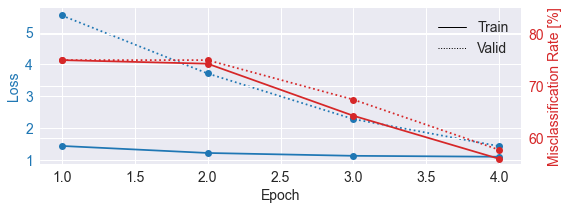

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()